# Force-Aware ProDMP

## Imports

In [12]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from copy import deepcopy

import sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), '.'))
from faprodmp import get_faprodmp, force_condition, blend_trajectories

## Load Data

In [13]:
POSITION_FEATURES = [ 'ee_pos_x', 'ee_pos_y', 'ee_pos_z' ]
FORCE_FEATURES = [ 'ee_wrench_desired_x', 'ee_wrench_desired_y', 'ee_wrench_desired_z' ]

In [14]:
trajectories = list()
for filename in os.listdir('./demo_trajectories'):
    if filename.endswith('.csv'):
        df = pd.read_csv(f'./demo_trajectories/{filename}', index_col=0)
        df = df[POSITION_FEATURES + FORCE_FEATURES]
        trajectories.append(df)
print(len(trajectories))

10


### Visualize

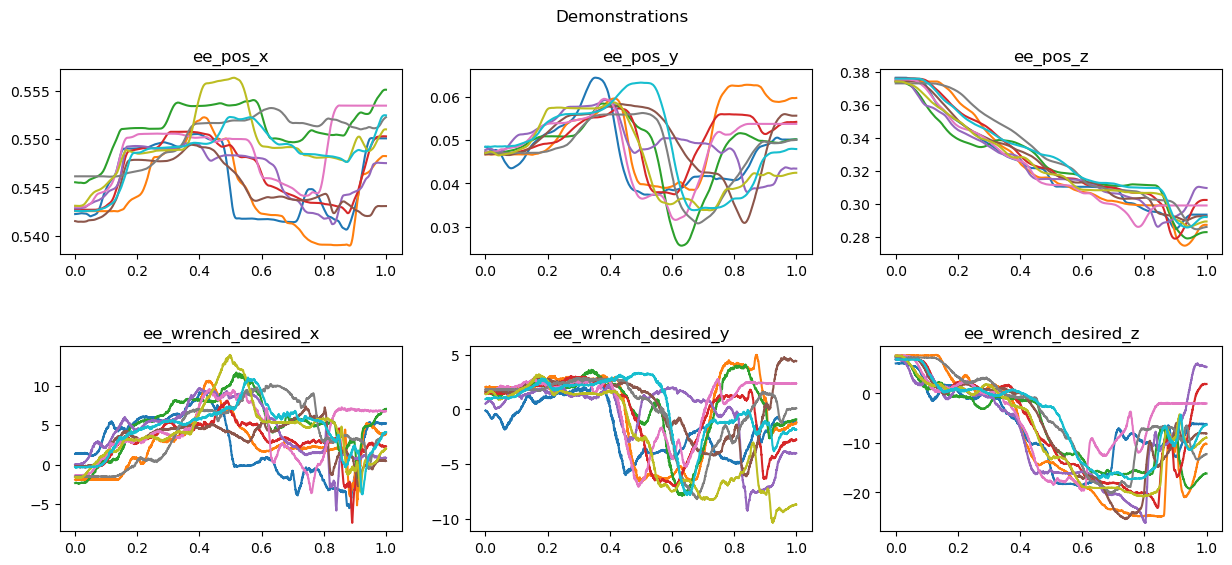

In [15]:
fig, axs = plt.subplots(2, len(POSITION_FEATURES), figsize=(5*len(POSITION_FEATURES),3 * 2))
fig.suptitle('Demonstrations')
plt.subplots_adjust(hspace=0.5)
for feature_idx in range(len(POSITION_FEATURES)):
    axs[0][feature_idx].set_title(POSITION_FEATURES[feature_idx])
    for traj_idx in range(len(trajectories)):
        axs[0][feature_idx].plot(trajectories[traj_idx][POSITION_FEATURES[feature_idx]])
for feature_idx in range(len(FORCE_FEATURES)):
    axs[1][feature_idx].set_title(FORCE_FEATURES[feature_idx])
    for traj_idx in range(len(trajectories)):
        axs[1][feature_idx].plot(trajectories[traj_idx][FORCE_FEATURES[feature_idx]])

# Display the plot
plt.show()

## Generate initial FA-ProDMP encoding

In [16]:
NUM_BASIS = 20
fa_prodmp = get_faprodmp(trajectories, POSITION_FEATURES,FORCE_FEATURES, NUM_BASIS )

### Visualize

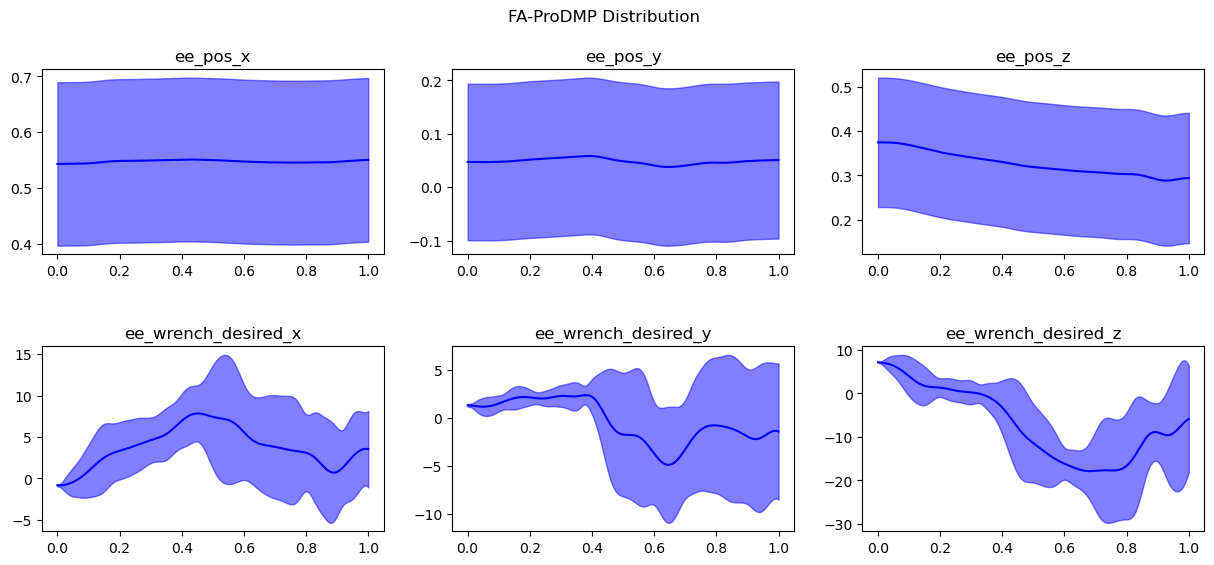

In [17]:
STD_SCALE = 2

fig, axs = plt.subplots(2, len(POSITION_FEATURES), figsize=(5*len(POSITION_FEATURES),3*2))
fig.suptitle('FA-ProDMP Distribution')
plt.subplots_adjust(hspace=0.5)
# plot for position
for feature_idx, feature_name in enumerate(POSITION_FEATURES + FORCE_FEATURES):
    row_idx = 0 if feature_idx < len(POSITION_FEATURES) else 1
    col_idx = feature_idx % len(POSITION_FEATURES)
    axs[row_idx][col_idx].set_title(feature_name)
    mean = fa_prodmp.get_traj_pos()[:,feature_idx]
    std = fa_prodmp.get_traj_pos_std()[:,feature_idx]
    axs[row_idx][col_idx].fill_between(x = fa_prodmp.times,
                                y1 = mean - STD_SCALE * std,
                                y2 = mean + STD_SCALE * std,
                                color = 'blue',
                                alpha = 0.5)
    axs[row_idx][col_idx].plot(fa_prodmp.times, mean, color='blue')
# Display the plot
plt.show()

**NOTE**: The position std visualization is caused by a bug in the MP_PyTorch package

## Condition on a measured Force

In [18]:
MEASUREMENT_PHASE = 0.75
MEASUREMENT_PHASE_IDX = torch.argmin(torch.abs(fa_prodmp.times - MEASUREMENT_PHASE))
MEASURED_FORCES = deepcopy(fa_prodmp.get_traj_pos()[MEASUREMENT_PHASE_IDX,len(POSITION_FEATURES):]).unsqueeze(1) # copy expected forces
MEASURED_FORCES[2] = -30 # set z force to -30 N


In [19]:
conditioned_fa_prodmp = force_condition(fa_prodmp=fa_prodmp,
                                        current_trajectory=fa_prodmp.get_traj_pos(),
                                        time_idx=MEASUREMENT_PHASE_IDX,
                                        measured_forces=MEASURED_FORCES,
                                        force_threshold=1 # N
                                    )

### Visualize

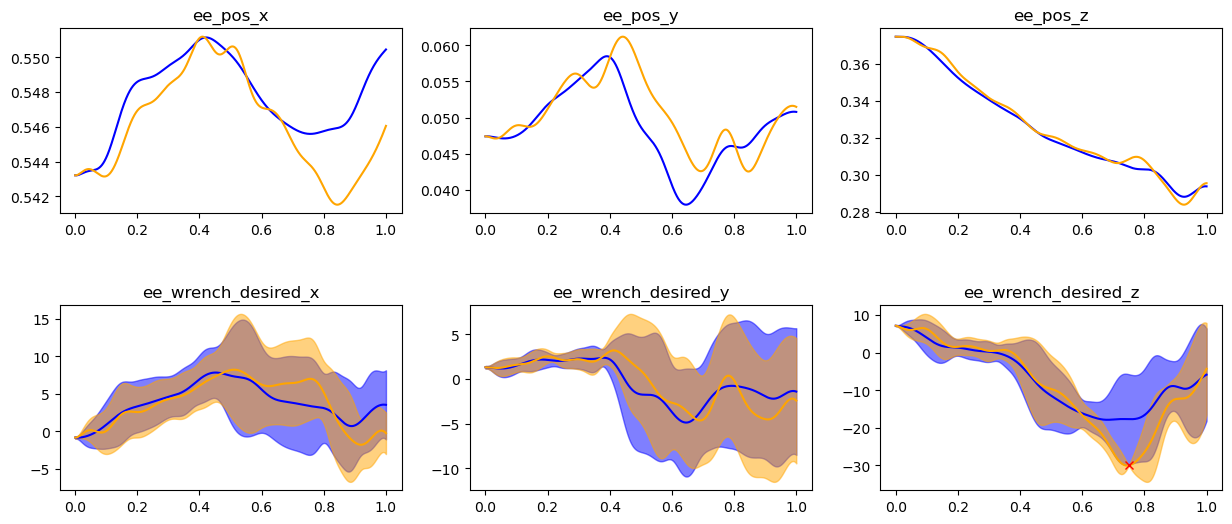

In [20]:
STD_SCALE = 2

fig, axs = plt.subplots(2, len(POSITION_FEATURES), figsize=(5*len(POSITION_FEATURES),3*2))
plt.subplots_adjust(hspace=0.5)
# plot for demonstrator
for feature_idx, feature_name in enumerate(POSITION_FEATURES + FORCE_FEATURES):
    row_idx = 0 if feature_idx < len(POSITION_FEATURES) else 1
    col_idx = feature_idx % len(POSITION_FEATURES)

    axs[row_idx][col_idx].set_title(feature_name)

    # plot old distribution
    mean = fa_prodmp.get_traj_pos()[:,feature_idx]
    std = fa_prodmp.get_traj_pos_std()[:,feature_idx]
    if row_idx == 1:
        axs[row_idx][col_idx].fill_between(x = fa_prodmp.times,
                                    y1 = mean - STD_SCALE * std,
                                    y2 = mean + STD_SCALE * std,
                                    color = 'blue',
                                    alpha = 0.5)
    axs[row_idx][col_idx].plot(fa_prodmp.times, mean, color='blue')

    # plot new distribution
    mean = conditioned_fa_prodmp.get_traj_pos()[:,feature_idx]
    std = conditioned_fa_prodmp.get_traj_pos_std()[:,feature_idx]
    if row_idx == 1:
        axs[row_idx][col_idx].fill_between(x = conditioned_fa_prodmp.times,
                                    y1 = mean - STD_SCALE * std,
                                    y2 = mean + STD_SCALE * std,
                                    color = 'orange',
                                    alpha = 0.5)
    axs[row_idx][col_idx].plot(conditioned_fa_prodmp.times, mean, color='orange')

#plot conditioning
axs[1][2].plot(
    MEASUREMENT_PHASE,
    MEASURED_FORCES[2],
    'rx')

# Display the plot
plt.show()

## Trajectory Blending

In [21]:
blended_trajectory = blend_trajectories(traj_old = fa_prodmp.get_traj_pos(),
                                        traj_new = conditioned_fa_prodmp.get_traj_pos(),
                                        blend_time_idx= MEASUREMENT_PHASE_IDX,
                                        time_scale = 12 #s
                                    )

### Visualize

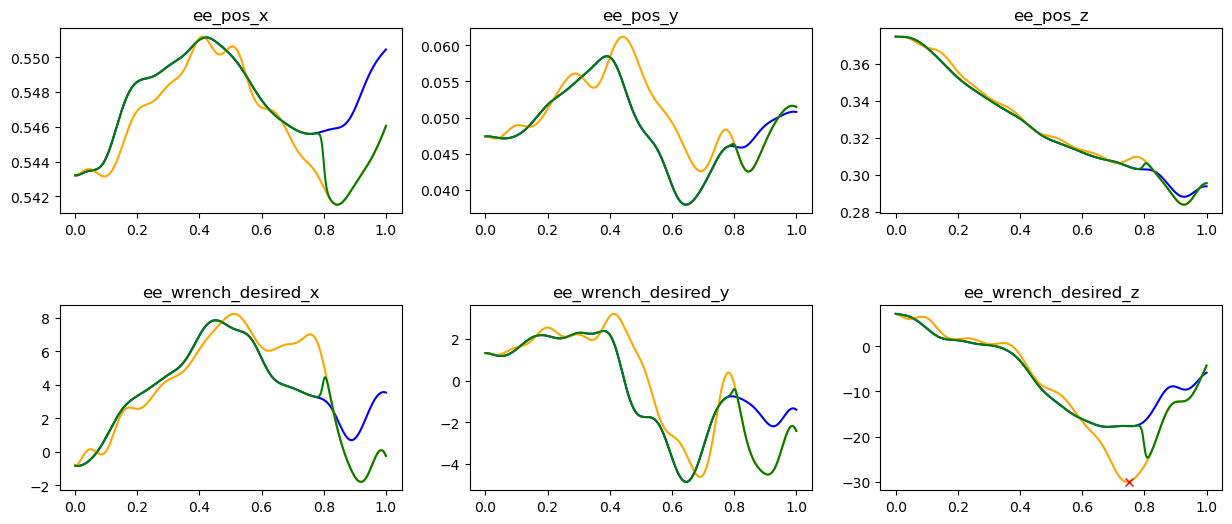

In [22]:

STD_SCALE = 2

fig, axs = plt.subplots(2, len(POSITION_FEATURES), figsize=(5*len(POSITION_FEATURES),3*2))
plt.subplots_adjust(hspace=0.5)
# plot for demonstrator
for feature_idx, feature_name in enumerate(POSITION_FEATURES + FORCE_FEATURES):
    row_idx = 0 if feature_idx < len(POSITION_FEATURES) else 1
    col_idx = feature_idx % len(POSITION_FEATURES)

    axs[row_idx][col_idx].set_title(feature_name)

    # plot old trajectory
    mean = fa_prodmp.get_traj_pos()[:,feature_idx]
    axs[row_idx][col_idx].plot(fa_prodmp.times, mean, color='blue')

    # plot new trajectory
    mean = conditioned_fa_prodmp.get_traj_pos()[:,feature_idx]
    axs[row_idx][col_idx].plot(conditioned_fa_prodmp.times, mean, color='orange')

    # plot blended trajectory
    mean = blended_trajectory[:,feature_idx]
    axs[row_idx][col_idx].plot(fa_prodmp.times, mean, color='green')

#plot conditioning
axs[1][2].plot(
    MEASUREMENT_PHASE,
    MEASURED_FORCES[2],
    'rx')

# Display the plot
plt.show()